In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
#build vocabulaty of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
#build the dataset
block_size = 3 #context length: how many characters to look at to predict the next one?

def build_dataset(words):
    X,Y = [],[]
    for w in words: #all words
        
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop the first element and apend the new one

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1  = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])            #80%
Xdev, Ydev = build_dataset(words[n1:n2])        #10%
Xte, Yte = build_dataset(words[n2:])            #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
#MLP Revisited
n_embd = 10 #dimentionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) #for reproducibility
C = torch.randn((vocab_size,n_embd), generator=g) #embedding layer

W1 = torch.randn((block_size*n_embd,200), generator=g) #first layer
b1 = torch.randn(n_hidden, generator=g) #biases for first layer

W2 = torch.randn((n_hidden,vocab_size), generator=g) #second layer
b2 = torch.randn(vocab_size, generator=g) #biases for second layer

parameters = [C, W1, b1, W2, b2] #all the parameters

for p in parameters:
    p.requires_grad = True #enabling gradients for all parameters

print(sum(p.nelement() for p in parameters)) #total no. of parameters

11897


In [6]:
stepi = []
lossi = []
max_steps = 20000
batch_size = 32

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) #randomly sample 32 numbers from 0 to 228146
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, Yb) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step lr decay
    for p in parameters:
        p.data += -lr*p.grad #updating the parameters

    #trackstats
    if i%1000 == 0: #print evey 1000th step
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

print('Training Loss:', loss.item())

      0/  20000: 27.8817
   1000/  20000: 4.0763
   2000/  20000: 3.0432
   3000/  20000: 2.9293
   4000/  20000: 2.3651
   5000/  20000: 2.3953
   6000/  20000: 2.3735
   7000/  20000: 2.8519
   8000/  20000: 2.4473
   9000/  20000: 2.5038
  10000/  20000: 2.8465
  11000/  20000: 2.0805
  12000/  20000: 2.4704
  13000/  20000: 2.4806
  14000/  20000: 2.9589
  15000/  20000: 2.2172
  16000/  20000: 2.5939
  17000/  20000: 2.6985
  18000/  20000: 2.4330
  19000/  20000: 2.3111
Training Loss: 2.054908275604248


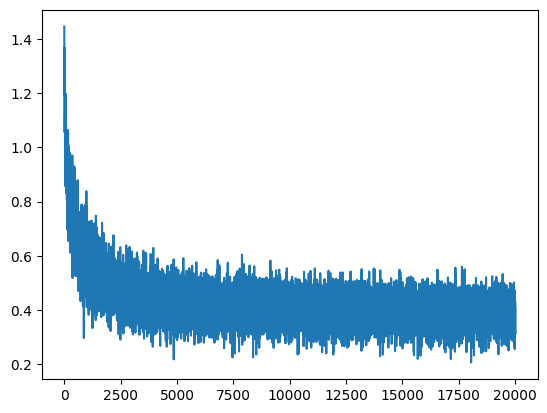

In [7]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() #this decorator disables gradient tracking
                 #whatever happens in this function below, it instructs pytorch
                 #to never require gradients for these operations since pytorch usually keeps track of gradients in anticipation of a backward pass
                 #but yaha koi backward pass nahi hai!
                 #for efficiency
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')

split_loss('train')
split_loss('val')

In [ ]:
#Sample form the model
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(20):
    out = []
    context = [0] * block_size #initialise with all '...'
    while True:
        emb = C[torch.tensor([context])] #(1,block_size,d): 1st dim was the size of training set, but here we're generating only 1 example,
        h = torch.tanh(emb.view(1,-1)@W1+b1)
        logits = h@W2 +b2
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:]+[ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word


moha.
imyah.
see.
mad.
rylla.
ethantengrlee.
adejedieliigh.
porea.
eden.
sanana.
sephetormara.
noshabergaviana.
tin.
joselynn.
nikolanobemander.
yaralyehs.
lia.
myskolanihan.
sakyansun.
zakelijunett.


In [ ]:
#Deeper look at the code
#Initial loss, at 0th iteration is very high, Network is very confidently wrong .'. high initiall loss
# idially it must be low
#and we can have an idea of the loss to expect at the beginnning
#by thinking that at the start, the probab distrib of all of the characters 
#must be a uniform distribution, since we have no reason to think about why 
#some characters must be higher than others
-torch.tensot(1/27.0).log() #-log liklih of uniform distribution



In [ ]:
#4D example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -probs[1].log() #checking the probab of the 2nd character (assuming it to be next character)
print(probs, loss )
#But, if the probs are like uniform distribution (i.e. if all/most logits are near to 0)
#then it doesnt matter we check the loss for the 2nd character or 3rd or 4th etc..
#because all of them will have the same loss

#PURELY by chance it can happen that say 2nd character got high logit, 
#i.e. high probab
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
#then checking loss of 2nd chracter will give very very loww loss
#and even though this is good for us, but this could be a local minima
loss = -probs[1].log() 
print(probs, loss )

#But most of the times other characters will have high logits (fake counts)
#i.e. high probab to wrong other characters which will give us high loss
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) #these are near to 0
probs = F.softmax(logits, dim=0)
loss = -probs[1].log() #checking the probab of the 2nd character (assuming it to be next character)
print(logits, probs, loss)

logits = torch.randn(4) *10 #but if we make the logits high, then the prob will also be high, chances of 'wrong' probs being high also increases -> and hence our loss increases
probs = F.softmax(logits, dim=0)
loss = -probs[1].log() #checking the probab of the 2nd character (assuming it to be next character)
print(logits, probs, loss )

#similarly, if our logits are even more extreme, then we'll get higher probabs, i.e. higher chance of getting 'wrong' probs high -> i.e. even high loss
#so, we need some kind of normalisation of logits
#to make the loss independent of the scale of logits


tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)
tensor([0.0066, 0.9802, 0.0066, 0.0066]) tensor(0.0200)
tensor([-0.4403,  0.6508, -0.2400,  0.3649]) tensor([0.1345, 0.4004, 0.1643, 0.3008]) tensor(0.9153)
tensor([ 4.7755, -1.6245, 10.0559,  4.4860]) tensor([5.0454e-03, 8.3833e-06, 9.9117e-01, 3.7771e-03]) tensor(11.6893)


In [17]:
#Let us re run the model training, and lets stop the model after 1st iteration

stepi = []
lossi = []
max_steps = 20000
batch_size = 32

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) #randomly sample 32 numbers from 0 to 228146
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, Yb) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step lr decay
    for p in parameters:
        p.data += -lr*p.grad #updating the parameters

    #trackstats
    if i%1000 == 0: #print evey 1000th step
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

    break

print('Training Loss:', loss.item())

      0/  20000: 27.8817
Training Loss: 27.881732940673828


In [ ]:
#such a high initall loss is because the logits are taking extrem values
logits[0] #lets see first row of logits
#so, we need logits to be nearer to 0, i.e. less extreme

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [24]:
#So, we modify our nextwork:

#MLP Revisited
n_embd = 10 #dimentionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd,200), generator=g) 
b1 = torch.randn(n_hidden, generator=g)  
W2 = torch.randn((n_hidden,vocab_size), generator=g) *0.01 #scale down W2 to make the logits closer to 0
b2 = torch.randn(vocab_size, generator=g)  *0 #we want b2 to be 0 initially, since we want logits to be nearer to 0 (or apas me pass)

parameters = [C, W1, b1, W2, b2] #all the parameters

for p in parameters:
    p.requires_grad = True #enabling gradients for all parameters

print(sum(p.nelement() for p in parameters)) #total no. of parameters

11897


In [25]:
#Let us re run the model training, and lets stop the model after 1st iteration

stepi = []
lossi = []
max_steps = 20000
batch_size = 32

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) #randomly sample 32 numbers from 0 to 228146
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, Yb) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step lr decay
    for p in parameters:
        p.data += -lr*p.grad #updating the parameters

    #trackstats
    if i%1000 == 0: #print evey 1000th step
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

    

print('Training Loss:', loss.item())
#initially loss is much less now
#we can scale down W2 even lower to get even smaller loss
#let us run it for more iterations

      0/  20000: 3.3221
   1000/  20000: 2.0833
   2000/  20000: 2.3735
   3000/  20000: 2.2160
   4000/  20000: 2.3154
   5000/  20000: 2.3121
   6000/  20000: 2.2268
   7000/  20000: 2.3368
   8000/  20000: 1.9117
   9000/  20000: 2.1829
  10000/  20000: 2.1900
  11000/  20000: 1.9048
  12000/  20000: 2.3158
  13000/  20000: 2.2492
  14000/  20000: 2.7875
  15000/  20000: 2.0552
  16000/  20000: 2.4447
  17000/  20000: 2.2630
  18000/  20000: 1.9778
  19000/  20000: 2.4615
Training Loss: 1.7331013679504395


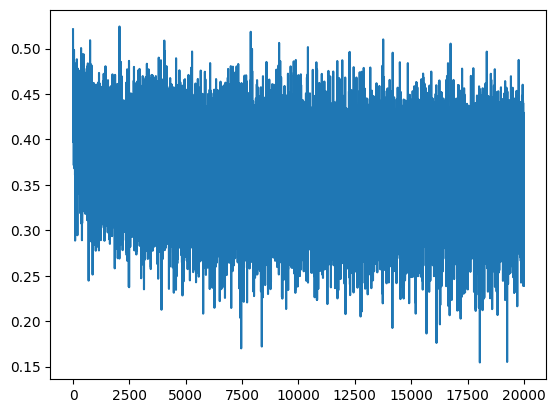

In [26]:
plt.plot(lossi)

In [ ]:
#We dont get that 'Hockey' shape of the loss curve.
#becuase networks first try to 'squash' the logits into a uniform distribution
#and then try to rearrange the logits to the distribution of the training data
#But here, we did that initial 'easy gains' part ourselves so that our model can focus on hard gains

In [27]:
@torch.no_grad() 
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')

split_loss('train')
split_loss('val')

train loss: 2.2784
val loss: 2.3086


Problem 2

In [ ]:
#But, can we keep the weights of W2 as 0?

n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd,200), generator=g) 
b1 = torch.randn(n_hidden, generator=g)  
W2 = torch.randn((n_hidden,vocab_size), generator=g) *0 #w2 = 0
b2 = torch.randn(vocab_size, generator=g)  *0 

parameters = [C, W1, b1, W2, b2] 

for p in parameters:
    p.requires_grad = True 

print(sum(p.nelement() for p in parameters)) 